In [1]:
!pip install pandas streamlit numpy plotly scikit-learn xgboost matplotlib

  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.0-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import glob
import csv

# Orden estándar de columnas
expected_columns = [
    "id", "ciudad", "entidad_remitente", "correo", "direccion", "funcionario", "fecha_banco",
    "fecha_oficio", "referencia", "cuenta", "identificacion", "tipo_identificacion_tipo", "montoaembargar",
    "nombres", "expediente", "mes", "entidad_bancaria", "estado_embargo", "tipo_documento",
    "tipo_embargo", "estado_demandado", "es_cliente", "tipo_carta"
]
num_expected = len(expected_columns)

csv_files = glob.glob("consulta detalle embargos-*.csv")
dataframes = []
log_corregidas, log_omitidas = [], []

for input_file in csv_files:
    print(f"Leyendo archivo: {input_file}")
    rows = []
    with open(input_file, encoding="utf-8") as infile:
        reader = csv.reader(infile)
        headers = next(reader)
        for idx, row in enumerate(reader, start=2):  # Empieza en 2 por el header
            # Reparar filas con menos columnas (rellena con '')
            if len(row) < num_expected:
                row = row + [''] * (num_expected - len(row))
                log_corregidas.append((input_file, idx, 'faltantes', len(row)))
            # Reparar filas con más columnas (por comas en dirección/nombres)
            if len(row) > num_expected:
                # Heurística: pega campos extra en "direccion" (col 4)
                extra = len(row) - num_expected
                direccion = ','.join(row[4:4+1+extra])
                fixed = row[:4] + [direccion] + row[4+1+extra:]
                if len(fixed) == num_expected:
                    row = fixed
                    log_corregidas.append((input_file, idx, 'excedente', len(row)))
                else:
                    log_omitidas.append((input_file, idx, len(row), row))
                    continue  # Omitir fila irrecuperable
            # Asegura que el orden y cantidad de columnas sea correcto
            if len(row) == num_expected:
                rows.append(row)
            else:
                log_omitidas.append((input_file, idx, len(row), row))
    df_temp = pd.DataFrame(rows, columns=expected_columns)
    dataframes.append(df_temp)

# Unión de todo
df = pd.concat(dataframes, ignore_index=True)

# --- Limpieza y normalización ---
# Númericas
df['montoaembargar'] = pd.to_numeric(df['montoaembargar'], errors='coerce').fillna(0)

# es_cliente: binariza bien todas las variantes, evita problemas de codificación futura
def clean_es_cliente(val):
    v = str(val).strip().upper()
    return 1 if v in {'1', 'SI_ES_CLIENTE', 'CLIENTE', 'SI', 'SÍ', 'TRUE', 'Y', 'YES'} else 0

df['es_cliente'] = df['es_cliente'].apply(clean_es_cliente).astype(int)

# Categóricas: upper, strip y sin nulos (evita valores 'nan' de string)
cat_cols = ['entidad_bancaria', 'ciudad', 'entidad_remitente', 'tipo_documento', 'tipo_embargo', 'estado_embargo', 'estado_demandado', 'tipo_carta', 'mes']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.upper().replace({'NAN': '', 'NONE': '', 'NULL': ''})

# Opcional: agrupa clases raras si hay muchas (puedes ajustar umbral)
for col in ['tipo_embargo', 'estado_embargo']:
    vc = df[col].value_counts()
    raros = vc[vc < 10].index
    df.loc[df[col].isin(raros), col] = 'OTRO'

# Limpia fechas
for col in ['fecha_banco', 'fecha_oficio']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Muestra por mes (ajusta a tu necesidad)
frac_muestra = 0.07
n_muestra = None
df_muestreado = df.groupby('mes', group_keys=False).apply(
    lambda x: x.sample(frac=frac_muestra, random_state=42) if n_muestra is None else x.sample(n=min(n_muestra, len(x)), random_state=42)
).reset_index(drop=True)

# Guarda resultado
output_file = "embargos_consolidado_mensual.csv"
df_muestreado.to_csv(output_file, index=False)
print(f"\nArchivo final consolidado y muestreado: {output_file}")
print(f"Filas originales: {len(df)}, tras muestreo: {len(df_muestreado)}")
print("\nEjemplo de datos:")
print(df_muestreado.head())

# Resumen de logs
print(f"\nFilas corregidas: {len(log_corregidas)}")
print(f"Filas omitidas definitivamente: {len(log_omitidas)}")
if log_omitidas:
    print("Ejemplo de líneas omitidas:", log_omitidas[:2])


Leyendo archivo: consulta detalle embargos-2023-01.csv
Leyendo archivo: consulta detalle embargos-2023-02.csv
Leyendo archivo: consulta detalle embargos-2024-01.csv
Leyendo archivo: consulta detalle embargos-2024-02.csv


C:\Users\FaberOs\AppData\Local\Temp\ipykernel_23116\3618614130.py:83: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_muestreado = df.groupby('mes', group_keys=False).apply(



Archivo final consolidado y muestreado: embargos_consolidado_mensual.csv
Filas originales: 2227458, tras muestreo: 155924

Ejemplo de datos:
            id       ciudad  \
0  23052600002        HONDA   
1  23053101021  BUCARAMANGA   
2  23052700466   BOGOTÁ D.C   
3  23052901757       IBAGUÉ   
4  23052501495  BUCARAMANGA   

                                   entidad_remitente  \
0                          MUNICIPIO DE HONDA TOLIMA   
1                                               DIAN   
2  OFICINA DE APOYO PARA LOS JUZGADOS CIVILES MUN...   
3  JUZGADO PRIMERO DE PEQUEÑAS CAUSAS Y COMPETENC...   
4      JUZGADO QUINCE CIVIL MUNICIPAL DE BUCARAMANGA   

                                             correo  \
0  notificacionjudicialhacienda@honda-tolima.gov.co   
1               embarprodpa@scotiabankcolpatria.com   
2                                                     
3            j01pqccmiba@cendoj.ramajudicial.gov.co   
4               j15cmbuc@cendoj.ramajudicial.gov.co   

   

=== REGRESIÓN: Oficios por mes ===
RMSE: 2625.697716798337
MAE: 1850.2935791015625
Promedio real: 9567.0


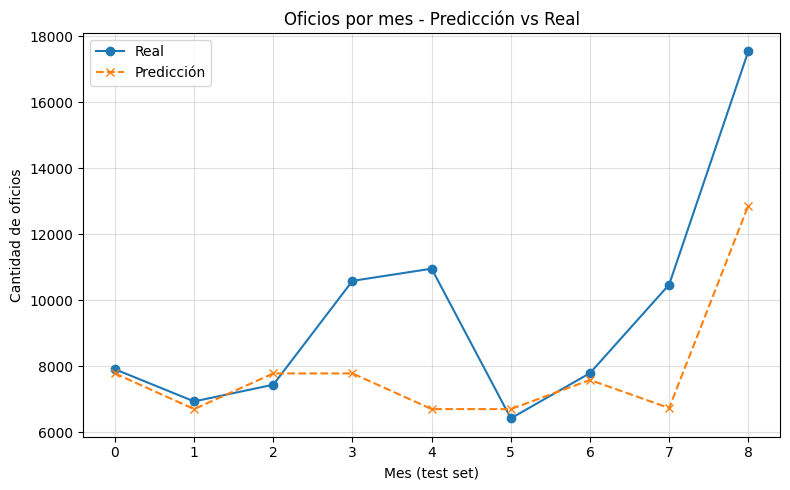


=== REGRESIÓN: Demandados únicos por mes ===
RMSE: 2437.3319429244757
MAE: 1742.52685546875
Promedio real: 8763.0


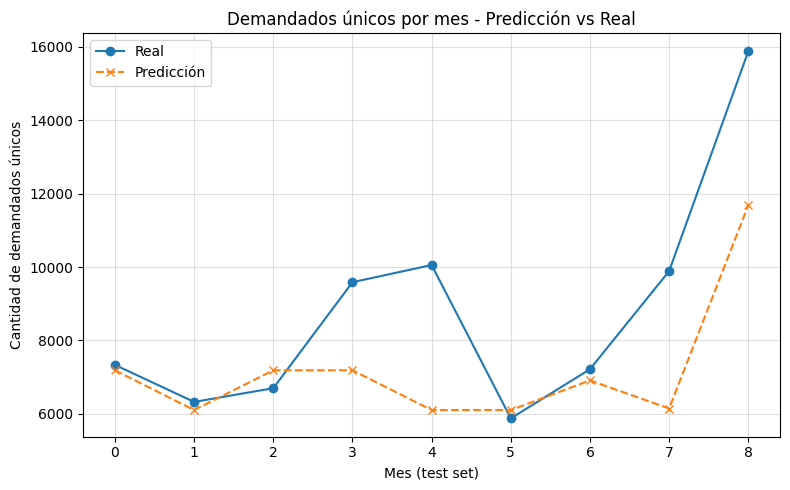

C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:24:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== CLASIFICACIÓN: Coactivo o Judicial ===
              precision    recall  f1-score   support

    COACTIVO       0.99      0.97      0.98     22680
    JUDICIAL       0.91      0.98      0.94      8261
        OTRO       0.00      0.00      0.00         1
SIN_PROCESAR       0.75      0.75      0.75         4

    accuracy                           0.97     30946
   macro avg       0.66      0.67      0.67     30946
weighted avg       0.97      0.97      0.97     30946



C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:24:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== CLASIFICACIÓN: Estado de oficio ===
                       precision    recall  f1-score   support

           CONFIRMADO       0.78      0.78      0.78     15989
              EMBARGO       1.00      1.00      1.00         5
            PROCESADO       0.76      0.76      0.76     14949
PROCESADO_CON_ERRORES       0.00      0.00      0.00         3

             accuracy                           0.77     30946
            macro avg       0.63      0.63      0.63     30946
         weighted avg       0.77      0.77      0.77     30946



C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:24:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== CLASIFICACIÓN: Cliente o no cliente ===
              precision    recall  f1-score   support

  NO_CLIENTE       0.99      0.87      0.93     28571
     CLIENTE       0.36      0.88      0.51      2375

    accuracy                           0.87     30946
   macro avg       0.67      0.87      0.72     30946
weighted avg       0.94      0.87      0.89     30946



C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:24:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== CLASIFICACIÓN: Ciudad ===
                                                  precision    recall  f1-score   support

                                         ACACIAS       0.70      0.81      0.75        67
                                  ACACIAS - META       1.00      0.20      0.33         5
                                    ACACIAS META       0.38      0.28      0.32        18
                                    ACACIAS-META       0.00      0.00      0.00         3
                                         ACACÌAS       0.00      0.00      0.00         3
                                         ACACÍAS       0.85      0.52      0.65        21
                                    ACACÍAS META       0.00      0.00      0.00         4
                                 AGUACHICA CESAR       0.00      0.00      0.00         3
                                         AGUAZUL       0.00      0.00      0.00         7
                                AGUAZUL CASANARE       0.35      0.2

C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:30:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== CLASIFICACIÓN: Entidad remitente ===
                                                                                                                                                                precision    recall  f1-score   support

                                                             ADMINISTRADORA DE LOS RECURSOS DEL SISTEMA GENERAL DE SEGURIDAD SOCIAL EN SALUD ( SGSSS ) - ADRES       0.00      0.00      0.00         2
                                                           ADMINISTRADORA DE LOS RECURSOS DEL SISTEMA GENERAL DE SEGURIDAD SOCIAL EN SALUD ( SGSSS ) - ADRES .       0.00      0.00      0.00         4
                                                                       ADMINISTRADORA DE LOS RECURSOS DEL SISTEMA GENERAL DE SEGURIDAD SOCIAL EN SALUD - ADRES       0.00      0.00      0.00        19
                                                                                                                                                         ADRE

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ----------- CARGA Y LIMPIEZA DE DATOS -----------
df = pd.read_csv('embargos_consolidado_mensual.csv')

def agrupar_otros(df, col, min_freq=10):
    freq = df[col].value_counts()
    otros = freq[freq < min_freq].index
    df[col] = df[col].apply(lambda x: 'OTRO' if x in otros else x)
    return df

for col in ['ciudad', 'entidad_remitente', 'tipo_embargo', 'estado_embargo']:
    df[col] = df[col].fillna('OTRO').astype(str).str.strip().str.upper()
    df = agrupar_otros(df, col, min_freq=10)

df['montoaembargar'] = pd.to_numeric(df['montoaembargar'], errors='coerce')

def clean_cliente(val):
    v = str(val).strip().upper()
    return 1 if v in {'1', 'SI', 'SI_ES_CLIENTE', 'CLIENTE', 'TRUE', 'SÍ', 'YES'} else 0
df['es_cliente_bin'] = df['es_cliente'].apply(clean_cliente).astype(int)

df['fecha_banco'] = pd.to_datetime(df['fecha_banco'], errors='coerce')
df['año'] = pd.to_numeric(df['fecha_banco'].dt.year, errors='coerce')
df['mes_num'] = pd.to_numeric(df['fecha_banco'].dt.month, errors='coerce')
df = df.dropna(subset=['año', 'mes_num']).copy()
df['año'] = df['año'].astype(int)
df['mes_num'] = df['mes_num'].astype(int)

from sklearn.preprocessing import LabelEncoder
le_ciudad = LabelEncoder(); le_entidad = LabelEncoder()
le_tipo_embargo = LabelEncoder(); le_estado_embargo = LabelEncoder()
df['ciudad_enc'] = le_ciudad.fit_transform(df['ciudad'])
df['entidad_remitente_enc'] = le_entidad.fit_transform(df['entidad_remitente'])
df['tipo_embargo_enc'] = le_tipo_embargo.fit_transform(df['tipo_embargo'])
df['estado_embargo_enc'] = le_estado_embargo.fit_transform(df['estado_embargo'])

df['mes_sin'] = np.sin(2 * np.pi * df['mes_num'] / 12.0)
df['mes_cos'] = np.cos(2 * np.pi * df['mes_num'] / 12.0)
df['mes_index'] = df['año'] * 12 + df['mes_num']

# ------- Lags y media móvil para regresión por mes -------
oficios_por_mes = df.groupby(['año','mes_num']).agg({
    'id': 'count',
    'identificacion': pd.Series.nunique,
    'montoaembargar': 'sum'
}).reset_index().sort_values(['año','mes_num'])

oficios_por_mes['oficios_lag1'] = oficios_por_mes['id'].shift(1)
oficios_por_mes['oficios_lag2'] = oficios_por_mes['id'].shift(2)
oficios_por_mes['oficios_lag3'] = oficios_por_mes['id'].shift(3)
oficios_por_mes['oficios_ma3'] = oficios_por_mes['id'].rolling(window=3).mean().shift(1)
oficios_por_mes['demandados_lag1'] = oficios_por_mes['identificacion'].shift(1)
oficios_por_mes['demandados_lag2'] = oficios_por_mes['identificacion'].shift(2)
oficios_por_mes['demandados_ma3'] = oficios_por_mes['identificacion'].rolling(window=3).mean().shift(1)
oficios_por_mes['mes_sin'] = np.sin(2 * np.pi * oficios_por_mes['mes_num'] / 12.0)
oficios_por_mes['mes_cos'] = np.cos(2 * np.pi * oficios_por_mes['mes_num'] / 12.0)

# ----------- VALIDACIÓN TEMPORAL -----------
ultimo_año = oficios_por_mes['año'].max()
train = oficios_por_mes[oficios_por_mes['año'] < ultimo_año]
test  = oficios_por_mes[oficios_por_mes['año'] == ultimo_año]

# ----------- REGRESIÓN: Total de oficios por mes -----------
features_reg = ['año','mes_num','mes_sin','mes_cos','oficios_lag1','oficios_lag2','oficios_lag3','oficios_ma3']
X_train = train[features_reg]
y_train = train['id']
X_test  = test[features_reg]
y_test  = test['id']

mask_train = ~(X_train.isnull().any(axis=1) | y_train.isnull())
mask_test = ~(X_test.isnull().any(axis=1) | y_test.isnull())
X_train_clean, y_train_clean = X_train[mask_train], y_train[mask_train]
X_test_clean,  y_test_clean  = X_test[mask_test],  y_test[mask_test]

regressor = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=7,
    objective='count:poisson', random_state=42
    base_score=np.mean(y_train_clean)
)
regressor.fit(X_train_clean, y_train_clean)
y_pred = regressor.predict(X_test_clean)

print("=== REGRESIÓN: Oficios por mes ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test_clean, y_pred)))
print("MAE:", mean_absolute_error(y_test_clean, y_pred))
print("Promedio real:", y_test_clean.mean())

plt.figure(figsize=(8,5))
plt.plot(range(len(y_test_clean)), y_test_clean.values, 'o-', label='Real')
plt.plot(range(len(y_pred)), y_pred, 'x--', label='Predicción')
plt.title("Oficios por mes - Predicción vs Real")
plt.xlabel("Mes (test set)")
plt.ylabel("Cantidad de oficios")
plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

# ----------- REGRESIÓN: Demandados únicos por mes -----------
features_dem = ['año','mes_num','mes_sin','mes_cos','demandados_lag1','demandados_lag2','demandados_ma3']
X_train_d = train[features_dem]
y_train_d = train['identificacion']
X_test_d  = test[features_dem]
y_test_d  = test['identificacion']

mask_train_d = ~(X_train_d.isnull().any(axis=1) | y_train_d.isnull())
mask_test_d = ~(X_test_d.isnull().any(axis=1) | y_test_d.isnull())
X_train_d_clean, y_train_d_clean = X_train_d[mask_train_d], y_train_d[mask_train_d]
X_test_d_clean,  y_test_d_clean  = X_test_d[mask_test_d],  y_test_d[mask_test_d]

regressor_dem = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=7,
    objective='count:poisson', random_state=42
    base_score=np.mean(y_train_d_clean)
)
regressor_dem.fit(X_train_d_clean, y_train_d_clean)
y_pred_d = regressor_dem.predict(X_test_d_clean)

print("\n=== REGRESIÓN: Demandados únicos por mes ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test_d_clean, y_pred_d)))
print("MAE:", mean_absolute_error(y_test_d_clean, y_pred_d))
print("Promedio real:", y_test_d_clean.mean())

plt.figure(figsize=(8,5))
plt.plot(range(len(y_test_d_clean)), y_test_d_clean.values, 'o-', label='Real')
plt.plot(range(len(y_pred_d)), y_pred_d, 'x--', label='Predicción')
plt.title("Demandados únicos por mes - Predicción vs Real")
plt.xlabel("Mes (test set)")
plt.ylabel("Cantidad de demandados únicos")
plt.legend(); plt.grid(True, alpha=0.4); plt.tight_layout(); plt.show()

# ----------- CLASIFICACIONES SOBRE DATAFRAME ORIGINAL -----------

# Variables para clasificación
features_clf = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'estado_embargo_enc', 'es_cliente_bin'
]

# --- 1. Coactivo o Judicial (tipo_embargo_enc) ---
X = df[features_clf]
y = df['tipo_embargo_enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                    subsample=0.9, colsample_bytree=0.8,
                    eval_metric='mlogloss', use_label_encoder=False,
                    tree_method="hist")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
le_tipo_embargo = LabelEncoder().fit(df['tipo_embargo'])
labels_report = np.unique(np.concatenate([y_test, y_pred]))
print("\n=== CLASIFICACIÓN: Coactivo o Judicial ===")
print(classification_report(
    y_test, y_pred,
    labels=labels_report,
    target_names=le_tipo_embargo.inverse_transform(labels_report),
    zero_division=0
))

# --- 2. Estado de oficio (embargo, desembargo, requerimientos) ---
features_clf2 = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'tipo_embargo_enc', 'es_cliente_bin'
]
y2 = df['estado_embargo_enc']
class_counts = y2.value_counts()
clases_validas = class_counts[class_counts >= 2].index
mask_validas = y2.isin(clases_validas)
X2_valid = df[features_clf2][mask_validas]
y2_valid = y2[mask_validas]

le_estado_embargo = LabelEncoder()
le_estado_embargo.fit(df['estado_embargo'][df['estado_embargo_enc'].isin(clases_validas)])

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2_valid, y2_valid, stratify=y2_valid, test_size=0.2, random_state=42)
clf2 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='mlogloss', use_label_encoder=False,
                     tree_method="hist")
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
labels_report2 = np.unique(np.concatenate([y_test2, y_pred2]))
print("\n=== CLASIFICACIÓN: Estado de oficio ===")
print(classification_report(
    y_test2, y_pred2,
    labels=labels_report2,
    target_names=le_estado_embargo.inverse_transform(labels_report2),
    zero_division=0
))

# --- 3. Cliente o no cliente ---
features_clf3 = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'tipo_embargo_enc', 'estado_embargo_enc'
]
y3 = df['es_cliente_bin']
X_train3, X_test3, y_train3, y_test3 = train_test_split(df[features_clf3], y3, stratify=y3, test_size=0.2, random_state=42)
scale_pos_weight = (y_train3 == 0).sum() / (y_train3 == 1).sum()
clf3 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='auc', use_label_encoder=False,
                     tree_method="hist", scale_pos_weight=scale_pos_weight)
clf3.fit(X_train3, y_train3)
y_pred3 = clf3.predict(X_test3)
labels_report3 = np.unique(np.concatenate([y_test3, y_pred3]))
print("\n=== CLASIFICACIÓN: Cliente o no cliente ===")
# Aquí son solo dos clases, puedes poner nombres fijos
print(classification_report(
    y_test3, y_pred3,
    labels=labels_report3,
    target_names=["NO_CLIENTE", "CLIENTE"],
    zero_division=0
))

# --- 4. Ciudad ---
features_for_ciudad = [c for c in features_clf + ['tipo_embargo_enc'] if c != 'ciudad_enc']
y4 = df['ciudad_enc']
X_train4, X_test4, y_train4, y_test4 = train_test_split(df[features_for_ciudad], y4, stratify=y4, test_size=0.2, random_state=42)
clf4 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='mlogloss', use_label_encoder=False,
                     tree_method="hist")
clf4.fit(X_train4, y_train4)
y_pred4 = clf4.predict(X_test4)
labels_report4 = np.unique(np.concatenate([y_test4, y_pred4]))
print("\n=== CLASIFICACIÓN: Ciudad ===")
print(classification_report(
    y_test4, y_pred4,
    labels=labels_report4,
    target_names=le_ciudad.inverse_transform(labels_report4),
    zero_division=0
))

# --- 5. Entidad remitente ---
features_for_entidad = [c for c in features_clf + ['tipo_embargo_enc'] if c != 'entidad_remitente_enc']
y5 = df['entidad_remitente_enc']
X_train5, X_test5, y_train5, y_test5 = train_test_split(df[features_for_entidad], y5, stratify=y5, test_size=0.2, random_state=42)
clf5 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='mlogloss', use_label_encoder=False,
                     tree_method="hist")
clf5.fit(X_train5, y_train5)
y_pred5 = clf5.predict(X_test5)
labels_report5 = np.unique(np.concatenate([y_test5, y_pred5]))
print("\n=== CLASIFICACIÓN: Entidad remitente ===")
print(classification_report(
    y_test5, y_pred5,
    labels=labels_report5,
    target_names=le_entidad.inverse_transform(labels_report5),
    zero_division=0
))


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# ----------- CARGA Y LIMPIEZA DE DATOS -----------
df = pd.read_csv('embargos_consolidado_mensual.csv')

def agrupar_otros(df, col, min_freq=10):
    freq = df[col].value_counts()
    otros = freq[freq < min_freq].index
    df[col] = df[col].apply(lambda x: 'OTRO' if x in otros else x)
    return df

for col in ['ciudad', 'entidad_remitente', 'tipo_embargo', 'estado_embargo']:
    df[col] = df[col].fillna('OTRO').astype(str).str.strip().str.upper()
    df = agrupar_otros(df, col, min_freq=10)

df['montoaembargar'] = pd.to_numeric(df['montoaembargar'], errors='coerce')
def clean_cliente(val):
    v = str(val).strip().upper()
    return 1 if v in {'1', 'SI', 'SI_ES_CLIENTE', 'CLIENTE', 'TRUE', 'SÍ', 'YES'} else 0
df['es_cliente_bin'] = df['es_cliente'].apply(clean_cliente).astype(int)

df['fecha_banco'] = pd.to_datetime(df['fecha_banco'], errors='coerce')
df['año'] = pd.to_numeric(df['fecha_banco'].dt.year, errors='coerce')
df['mes_num'] = pd.to_numeric(df['fecha_banco'].dt.month, errors='coerce')
df = df.dropna(subset=['año', 'mes_num']).copy()
df['año'] = df['año'].astype(int)
df['mes_num'] = df['mes_num'].astype(int)

le_ciudad = LabelEncoder(); le_entidad = LabelEncoder()
le_tipo_embargo = LabelEncoder(); le_estado_embargo = LabelEncoder()
df['ciudad_enc'] = le_ciudad.fit_transform(df['ciudad'])
df['entidad_remitente_enc'] = le_entidad.fit_transform(df['entidad_remitente'])
df['tipo_embargo_enc'] = le_tipo_embargo.fit_transform(df['tipo_embargo'])
df['estado_embargo_enc'] = le_estado_embargo.fit_transform(df['estado_embargo'])

df['mes_sin'] = np.sin(2 * np.pi * df['mes_num'] / 12.0)
df['mes_cos'] = np.cos(2 * np.pi * df['mes_num'] / 12.0)
df['mes_index'] = df['año'] * 12 + df['mes_num']

# ------- Lags y media móvil para regresión por mes -------
oficios_por_mes = df.groupby(['año','mes_num']).agg({
    'id': 'count',
    'identificacion': pd.Series.nunique,
    'montoaembargar': 'sum'
}).reset_index().sort_values(['año','mes_num'])

oficios_por_mes['oficios_lag1'] = oficios_por_mes['id'].shift(1)
oficios_por_mes['oficios_lag2'] = oficios_por_mes['id'].shift(2)
oficios_por_mes['oficios_lag3'] = oficios_por_mes['id'].shift(3)
oficios_por_mes['oficios_ma3'] = oficios_por_mes['id'].rolling(window=3).mean().shift(1)
oficios_por_mes['demandados_lag1'] = oficios_por_mes['identificacion'].shift(1)
oficios_por_mes['demandados_lag2'] = oficios_por_mes['identificacion'].shift(2)
oficios_por_mes['demandados_ma3'] = oficios_por_mes['identificacion'].rolling(window=3).mean().shift(1)
oficios_por_mes['mes_sin'] = np.sin(2 * np.pi * oficios_por_mes['mes_num'] / 12.0)
oficios_por_mes['mes_cos'] = np.cos(2 * np.pi * oficios_por_mes['mes_num'] / 12.0)

# ----------- VALIDACIÓN TEMPORAL -----------
ultimo_año = oficios_por_mes['año'].max()
train = oficios_por_mes[oficios_por_mes['año'] < ultimo_año]
test  = oficios_por_mes[oficios_por_mes['año'] == ultimo_año]

# ----------- REGRESIÓN: Total de oficios por mes -----------
features_reg = ['año','mes_num','mes_sin','mes_cos','oficios_lag1','oficios_lag2','oficios_lag3','oficios_ma3']
X_train = train[features_reg]
y_train = train['id']
X_test  = test[features_reg]
y_test  = test['id']

mask_train = ~(X_train.isnull().any(axis=1) | y_train.isnull())
mask_test = ~(X_test.isnull().any(axis=1) | y_test.isnull())
X_train_clean, y_train_clean = X_train[mask_train], y_train[mask_train]
X_test_clean,  y_test_clean  = X_test[mask_test],  y_test[mask_test]

regressor = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=7,
    objective='count:poisson', random_state=42
    base_score=np.mean(y_train_d_clean)
)
regressor.fit(X_train_clean, y_train_clean)
y_pred = regressor.predict(X_test_clean)

# ----------- REGRESIÓN: Demandados únicos por mes -----------
features_dem = ['año','mes_num','mes_sin','mes_cos','demandados_lag1','demandados_lag2','demandados_ma3']
X_train_d = train[features_dem]
y_train_d = train['identificacion']
X_test_d  = test[features_dem]
y_test_d  = test['identificacion']

mask_train_d = ~(X_train_d.isnull().any(axis=1) | y_train_d.isnull())
mask_test_d = ~(X_test_d.isnull().any(axis=1) | y_test_d.isnull())
X_train_d_clean, y_train_d_clean = X_train_d[mask_train_d], y_train_d[mask_train_d]
X_test_d_clean,  y_test_d_clean  = X_test_d[mask_test_d],  y_test_d[mask_test_d]

regressor_dem = XGBRegressor(
    n_estimators=200, learning_rate=0.1, max_depth=7,
    objective='count:poisson', random_state=42
    base_score=np.mean(y_train_d_clean)
)
regressor_dem.fit(X_train_d_clean, y_train_d_clean)
y_pred_d = regressor_dem.predict(X_test_d_clean)

# ============ GUARDAR CSVs DE REGRESIÓN ============
# Oficios por mes
df_pred_oficios = test.iloc[mask_test.values][['año','mes_num']].copy()
df_pred_oficios['real_oficios'] = y_test_clean.values
df_pred_oficios['pred_oficios'] = y_pred
df_pred_oficios['mes'] = df_pred_oficios['año'].astype(str) + "-" + df_pred_oficios['mes_num'].astype(str).str.zfill(2)
df_pred_oficios[['mes', 'real_oficios', 'pred_oficios']].to_csv("predicciones_oficios_por_mes.csv", index=False)
print("CSV generado: predicciones_oficios_por_mes.csv")

# Demandados por mes
df_pred_demandados = test.iloc[mask_test_d.values][['año','mes_num']].copy()
df_pred_demandados['real_demandados'] = y_test_d_clean.values
df_pred_demandados['pred_demandados'] = y_pred_d
df_pred_demandados['mes'] = df_pred_demandados['año'].astype(str) + "-" + df_pred_demandados['mes_num'].astype(str).str.zfill(2)
df_pred_demandados[['mes', 'real_demandados', 'pred_demandados']].to_csv("predicciones_demandados_por_mes.csv", index=False)
print("CSV generado: predicciones_demandados_por_mes.csv")

# ============ CLASIFICACIONES Y MÉTRICAS ============
features_clf = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'estado_embargo_enc', 'es_cliente_bin'
]
# 1. Tipo Embargo (coactivo/judicial)
X = df[features_clf]
y = df['tipo_embargo_enc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
clf = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                    subsample=0.9, colsample_bytree=0.8,
                    eval_metric='mlogloss', use_label_encoder=False,
                    tree_method="hist")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
le_tipo_embargo = LabelEncoder().fit(df['tipo_embargo'])
labels_report = np.unique(np.concatenate([y_test, y_pred]))

# 2. Estado Oficio
features_clf2 = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'tipo_embargo_enc', 'es_cliente_bin'
]
y2 = df['estado_embargo_enc']
class_counts = y2.value_counts()
clases_validas = class_counts[class_counts >= 2].index
mask_validas = y2.isin(clases_validas)
X2_valid = df[features_clf2][mask_validas]
y2_valid = y2[mask_validas]
le_estado_embargo = LabelEncoder()
le_estado_embargo.fit(df['estado_embargo'][df['estado_embargo_enc'].isin(clases_validas)])
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2_valid, y2_valid, stratify=y2_valid, test_size=0.2, random_state=42)
clf2 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='mlogloss', use_label_encoder=False,
                     tree_method="hist")
clf2.fit(X_train2, y_train2)
y_pred2 = clf2.predict(X_test2)
labels_report2 = np.unique(np.concatenate([y_test2, y_pred2]))

# 3. Cliente/no cliente
features_clf3 = [
    'entidad_remitente_enc', 'mes_num', 'montoaembargar',
    'tipo_embargo_enc', 'estado_embargo_enc'
]
y3 = df['es_cliente_bin']
X_train3, X_test3, y_train3, y_test3 = train_test_split(df[features_clf3], y3, stratify=y3, test_size=0.2, random_state=42)
scale_pos_weight = (y_train3 == 0).sum() / (y_train3 == 1).sum()
clf3 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='auc', use_label_encoder=False,
                     tree_method="hist", scale_pos_weight=scale_pos_weight)
clf3.fit(X_train3, y_train3)
y_pred3 = clf3.predict(X_test3)
labels_report3 = np.unique(np.concatenate([y_test3, y_pred3]))

# 4. Ciudad
features_for_ciudad = [c for c in features_clf + ['tipo_embargo_enc'] if c != 'ciudad_enc']
y4 = df['ciudad_enc']
X_train4, X_test4, y_train4, y_test4 = train_test_split(df[features_for_ciudad], y4, stratify=y4, test_size=0.2, random_state=42)
clf4 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='mlogloss', use_label_encoder=False,
                     tree_method="hist")
clf4.fit(X_train4, y_train4)
y_pred4 = clf4.predict(X_test4)
labels_report4 = np.unique(np.concatenate([y_test4, y_pred4]))

# 5. Entidad Remitente
features_for_entidad = [c for c in features_clf + ['tipo_embargo_enc'] if c != 'entidad_remitente_enc']
y5 = df['entidad_remitente_enc']
X_train5, X_test5, y_train5, y_test5 = train_test_split(df[features_for_entidad], y5, stratify=y5, test_size=0.2, random_state=42)
clf5 = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1,
                     subsample=0.9, colsample_bytree=0.8,
                     eval_metric='mlogloss', use_label_encoder=False,
                     tree_method="hist")
clf5.fit(X_train5, y_train5)
y_pred5 = clf5.predict(X_test5)
labels_report5 = np.unique(np.concatenate([y_test5, y_pred5]))

# ============ GUARDAR METRICAS DE CLASIFICACIÓN =============
def report_to_df(report, modelo, target_names):
    df_metrics = pd.DataFrame(report).transpose().reset_index()
    df_metrics = df_metrics.rename(columns={'index': 'clase'})
    df_metrics['modelo'] = modelo
    df_metrics = df_metrics[df_metrics['clase'].isin(target_names)]
    df_metrics = df_metrics.rename(columns={
        'precision': 'precision',
        'recall': 'recall',
        'f1-score': 'f1',
        'support': 'soporte'
    })
    df_metrics = df_metrics[['modelo', 'clase', 'precision', 'recall', 'f1', 'soporte']]
    return df_metrics

dfs = []

report_te = classification_report(
    y_test, y_pred, output_dict=True,
    target_names=le_tipo_embargo.inverse_transform(labels_report), zero_division=0
)
dfs.append(report_to_df(report_te, "Tipo Embargo", le_tipo_embargo.inverse_transform(labels_report)))

report_ee = classification_report(
    y_test2, y_pred2, output_dict=True,
    target_names=le_estado_embargo.inverse_transform(labels_report2), zero_division=0
)
dfs.append(report_to_df(report_ee, "Estado Oficio", le_estado_embargo.inverse_transform(labels_report2)))

report_cli = classification_report(
    y_test3, y_pred3, output_dict=True,
    target_names=["NO_CLIENTE", "CLIENTE"], zero_division=0
)
dfs.append(report_to_df(report_cli, "Es Cliente", ["NO_CLIENTE", "CLIENTE"]))

report_ciud = classification_report(
    y_test4, y_pred4, output_dict=True,
    target_names=le_ciudad.inverse_transform(labels_report4), zero_division=0
)
dfs.append(report_to_df(report_ciud, "Ciudad", le_ciudad.inverse_transform(labels_report4)))

report_ent = classification_report(
    y_test5, y_pred5, output_dict=True,
    target_names=le_entidad.inverse_transform(labels_report5), zero_division=0
)
dfs.append(report_to_df(report_ent, "Entidad Remitente", le_entidad.inverse_transform(labels_report5)))

df_metrics_all = pd.concat(dfs, ignore_index=True)
df_metrics_all.to_csv("resultados_clasificaciones.csv", index=False)
print("CSV generado: resultados_clasificaciones.csv")

print("\n¡Todos los CSV están listos para usar en tu dashboard!")


CSV generado: predicciones_oficios_por_mes.csv
CSV generado: predicciones_demandados_por_mes.csv


C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:37:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:37:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:37:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\FaberOs\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:37:29] WARNING: 

CSV generado: resultados_clasificaciones.csv

¡Todos los CSV están listos para usar en tu dashboard!
